In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

Format of the file: age_gender_ethnicity_datetime 

In [2]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


In [3]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

In [4]:

# Convert the list to a pandas Series
ages_series = pd.Series(ages)

# Count the frequency of each age
age_counts = ages_series.value_counts()

# Print the frequencies
print(age_counts)

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Length: 104, dtype: int64


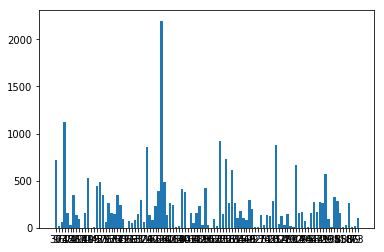

Max value: 99


In [5]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 1 Age: 21


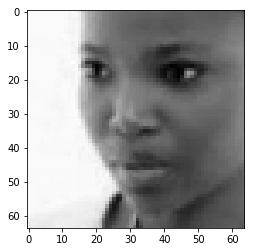

In [6]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 450
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [7]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

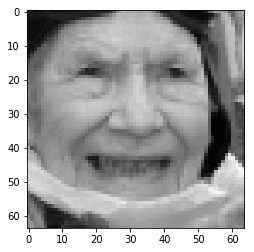

In [8]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [10]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [11]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

Using TensorFlow backend.


In [12]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [13]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 60, 60, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 30, 30, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [15]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 20, batch_size=64,shuffle = True)

Train on 18966 samples, validate on 4742 samples
Epoch 1/20
18966/18966 [==============================] - 10s 528us/step - loss: 0.7921 - dense_4_loss: 0.0993 - dense_10_loss: 0.6927 - dense_4_accuracy: 0.0140 - dense_10_accuracy: 0.5198 - val_loss: 0.7131 - val_dense_4_loss: 0.0263 - val_dense_10_loss: 0.6869 - val_dense_4_accuracy: 0.0245 - val_dense_10_accuracy: 0.5158
Epoch 2/20
18966/18966 [==============================] - 6s 325us/step - loss: 0.6581 - dense_4_loss: 0.0425 - dense_10_loss: 0.6158 - dense_4_accuracy: 0.0230 - dense_10_accuracy: 0.6343 - val_loss: 0.4869 - val_dense_4_loss: 0.0269 - val_dense_10_loss: 0.4591 - val_dense_4_accuracy: 0.0230 - val_dense_10_accuracy: 0.8142
Epoch 3/20
18966/18966 [==============================] - 6s 327us/step - loss: 0.5276 - dense_4_loss: 0.0345 - dense_10_loss: 0.4929 - dense_4_accuracy: 0.0251 - dense_10_accuracy: 0.7707 - val_loss: 0.3641 - val_dense_4_loss: 0.0237 - val_dense_10_loss: 0.3385 - val_dense_4_accuracy: 0.0245 - va

In [16]:
model.save('data.h5')

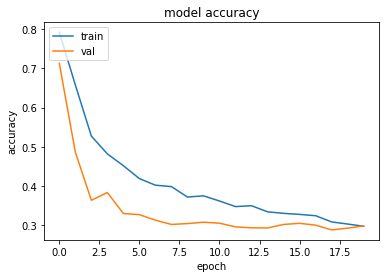

In [17]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

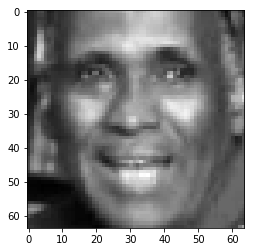

Actual Gender: Male Age: 54
Values: [array([[0.69389194]], dtype=float32), array([[0.03139896]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


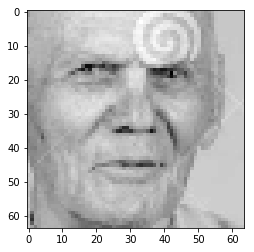

Actual Gender: Male Age: 82
Values: [array([[0.7500384]], dtype=float32), array([[0.00190228]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


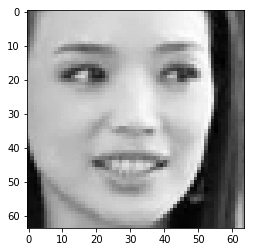

Actual Gender: Female Age: 24
Values: [array([[0.52259165]], dtype=float32), array([[0.97683126]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


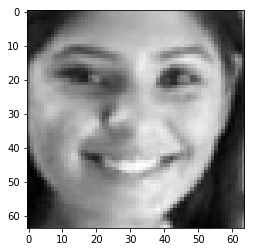

Actual Gender: Female Age: 21
Values: [array([[0.41331637]], dtype=float32), array([[0.9007234]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


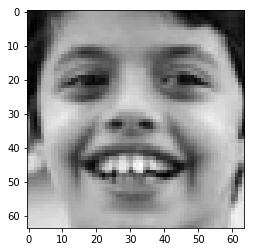

Actual Gender: Male Age: 7
Values: [array([[0.4356792]], dtype=float32), array([[0.26810148]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


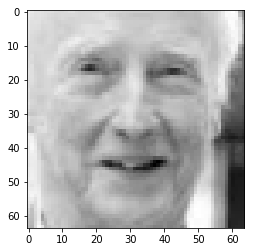

Actual Gender: Male Age: 76
Values: [array([[0.7348118]], dtype=float32), array([[0.01752608]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


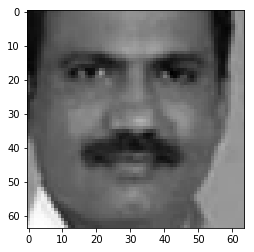

Actual Gender: Male Age: 34
Values: [array([[0.70752597]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


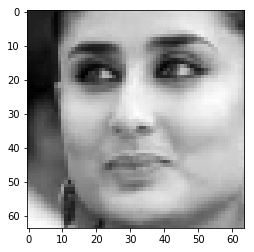

Actual Gender: Female Age: 25
Values: [array([[0.62210846]], dtype=float32), array([[0.9710448]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


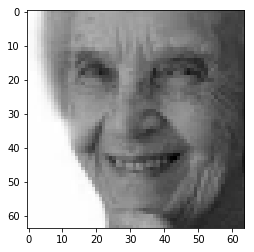

Actual Gender: Female Age: 79
Values: [array([[0.72054017]], dtype=float32), array([[0.89813215]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


In [18]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)